In [1]:
base_dir = "../input/mobile-price-classification/"

# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from time import time
import random as r

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer

# Helper Functions

In [3]:
def breaker():
    print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()
    
def getCol(x):
    return [col for col in x.columns]

def getObj(x):
    s = (x.dtypes == "object")
    return list(s[s].index)


# Data Handling

**Input**

In [4]:
tr_Set = pd.read_csv(base_dir + "train.csv")
ts_Set = pd.read_csv(base_dir + "test.csv")

breaker()
print("Training Set Shape :", repr(tr_Set.shape))
breaker()

for name in getCol(tr_Set):
    print(name)
breaker()


------------------------------

Training Set Shape : (2000, 21)

------------------------------

battery_power
blue
clock_speed
dual_sim
fc
four_g
int_memory
m_dep
mobile_wt
n_cores
pc
px_height
px_width
ram
sc_h
sc_w
talk_time
three_g
touch_screen
wifi
price_range

------------------------------



In [5]:
breaker()
print("Test Set Shape :", repr(ts_Set.shape))
breaker()

for name in getCol(ts_Set):
    print(name)
breaker()


------------------------------

Test Set Shape : (1000, 21)

------------------------------

id
battery_power
blue
clock_speed
dual_sim
fc
four_g
int_memory
m_dep
mobile_wt
n_cores
pc
px_height
px_width
ram
sc_h
sc_w
talk_time
three_g
touch_screen
wifi

------------------------------



**Processing**

In [6]:
X = tr_Set.iloc[:, :-1].copy().values
y = tr_Set.iloc[:, -1].copy().values

X_test = ts_Set.iloc[:, 1:].copy().values

X = X.astype(float)
X_test = X_test.astype(float)

y = y.astype(int)

sc_X = StandardScaler()
#X = sc_X.fit_transform(X)
#X_test = sc_X.transform(X)

num_features = X.shape[1]
num_classes  = len(set(y))

del tr_Set, ts_Set, 

**Dataset Template**

In [7]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
    
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [8]:
class CFG():
    tr_batch_size = 64
    ts_batch_size = 64
    va_batch_size = 64
    
    epochs = 50
    n_folds = 5
    
    IL = num_features
    HL_1 = [128]
    HL_2 = [128, 64]
    OL = num_classes
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = CFG()

ts_data_setup = DS(X_test, None, "test")
ts_data       = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

**Setup**

In [9]:
class MLP(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(MLP, this).__init__()
        
        this.HL = HL
        
        this.DP1 = nn.Dropout(p=0.2)
        this.DP2 = nn.Dropout(p=0.5)
        
        if len(HL) == 1:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))
            
            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], OL))
            
        elif len(HL) == 2:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))
            
            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], HL[1]))
            
            this.BN3 = nn.BatchNorm1d(HL[1])
            this.FC3 = WN(nn.Linear(HL[1], OL))
            
        else:
            raise NotImplementedError("Only supports Networks of depth 2 and 3")
            
    def getOptimizer(this, A_or_S=True, lr=1e-3, wd=0):
        if A_or_S:
            return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
        else:
            return optim.SGD(this.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    
    def forward(this, x):
        if len(this.HL) == 1:
            x = this.BN1(x)
            #x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            #x = this.DP2(x)
            x = F.log_softmax(this.FC2(x), dim=1)
            return x
        else:
            x = this.BN1(x)
            #x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            #x = this.DP2(x)
            x = F.relu(this.FC2(x))
            x = this.BN3(x)
            #x = this.DP2(x)
            x = F.log_softmax(this.FC3(x), dim=1)
            return x        

**ANN Helpers**

In [10]:
def train_fn(X=None, y=None, n_folds=None, HL_Used=None):
    breaker()
    print("Training ...")
    breaker()
    
    LP = []
    names = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    fold = 0
    
    start_time = time()
    for tr_idx, va_idx in StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
        print("Processing Fold {fold}".format(fold=fold+1))
        
        X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]
        
        tr_data_setup = DS(X_train, y_train.reshape(-1,1))
        va_data_setup = DS(X_valid, y_valid.reshape(-1,1))
        
        DLS = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
               "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)
              }
        
        torch.manual_seed(0)
        model = MLP(cfg.IL, HL_Used, cfg.OL)
        model.to(cfg.device)
        
        optimizer = model.getOptimizer()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, eps=1e-6, verbose=True)
        
        for e in range(cfg.epochs):
            epochLoss = {"train" : 0, "valid" : 0}
            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                lossPerPass = 0
                
                for feat, label in DLS[phase]:
                    feat, label = feat.to(cfg.device), label.to(cfg.device).view(-1)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(feat)
                        loss   = nn.NLLLoss()(output, label)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass += (loss.item() / label.shape[0])
                epochLoss[phase] = lossPerPass
            LP.append(epochLoss)
            scheduler.step(epochLoss["valid"])
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                name = "./Model_{ids}_Fold_{fold}.pt".format(ids=len(HL_Used), fold=fold)
                names.append(name)
                torch.save(model.state_dict(), name)
        fold += 1
    
    breaker()
    print("Time Taken to Train {f} folds for {e} epochs : {:.2f} minutes".format((time() - start_time)/60, f=n_folds, e=cfg.epochs))
    breaker()
    print("Best Loss :", repr(bestLoss))
    breaker()

    return LP, names, model

def eval_fn(model=None, names=None, dataloader=None, num_obs_test=None):
    y_pred = np.zeros((num_obs_test, 1))
    
    for name in names:
        Preds = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
        
        model.load_state_dict(torch.load(name))
        model.eval()
        
        for X in dataloader:
            X = X.to(cfg.device)
            with torch.no_grad():
                logProb = model(X)
            Prob = torch.exp(logProb)
            Pred = torch.argmax(Prob, dim=1)
            Preds = torch.cat((Preds, Pred.view(-1,1)), dim=0)
        Preds = Preds[cfg.ts_batch_size:].cpu().numpy()
        y_pred = np.add(y_pred, Preds)
    y_pred = np.divide(y_pred, len(names))
    return y_pred.astype(int)        

In [11]:
full_tr_data_setup = DS(X, None, "test")
full_tr_data = DL(full_tr_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

# Configuration 1


------------------------------

Training ...

------------------------------

Processing Fold 1
Epoch    40: reducing learning rate of group 0 to 1.0000e-04.
Epoch    46: reducing learning rate of group 0 to 1.0000e-05.
Processing Fold 2
Epoch    38: reducing learning rate of group 0 to 1.0000e-04.
Epoch    44: reducing learning rate of group 0 to 1.0000e-05.
Epoch    50: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3
Epoch    35: reducing learning rate of group 0 to 1.0000e-04.
Epoch    41: reducing learning rate of group 0 to 1.0000e-05.
Epoch    47: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4
Epoch    42: reducing learning rate of group 0 to 1.0000e-04.
Epoch    48: reducing learning rate of group 0 to 1.0000e-05.
Processing Fold 5
Epoch    46: reducing learning rate of group 0 to 1.0000e-04.

------------------------------

Time Taken to Train 5 folds for 50 epochs : 0.55 minutes

------------------------------

Best Loss : {'train': 0.05

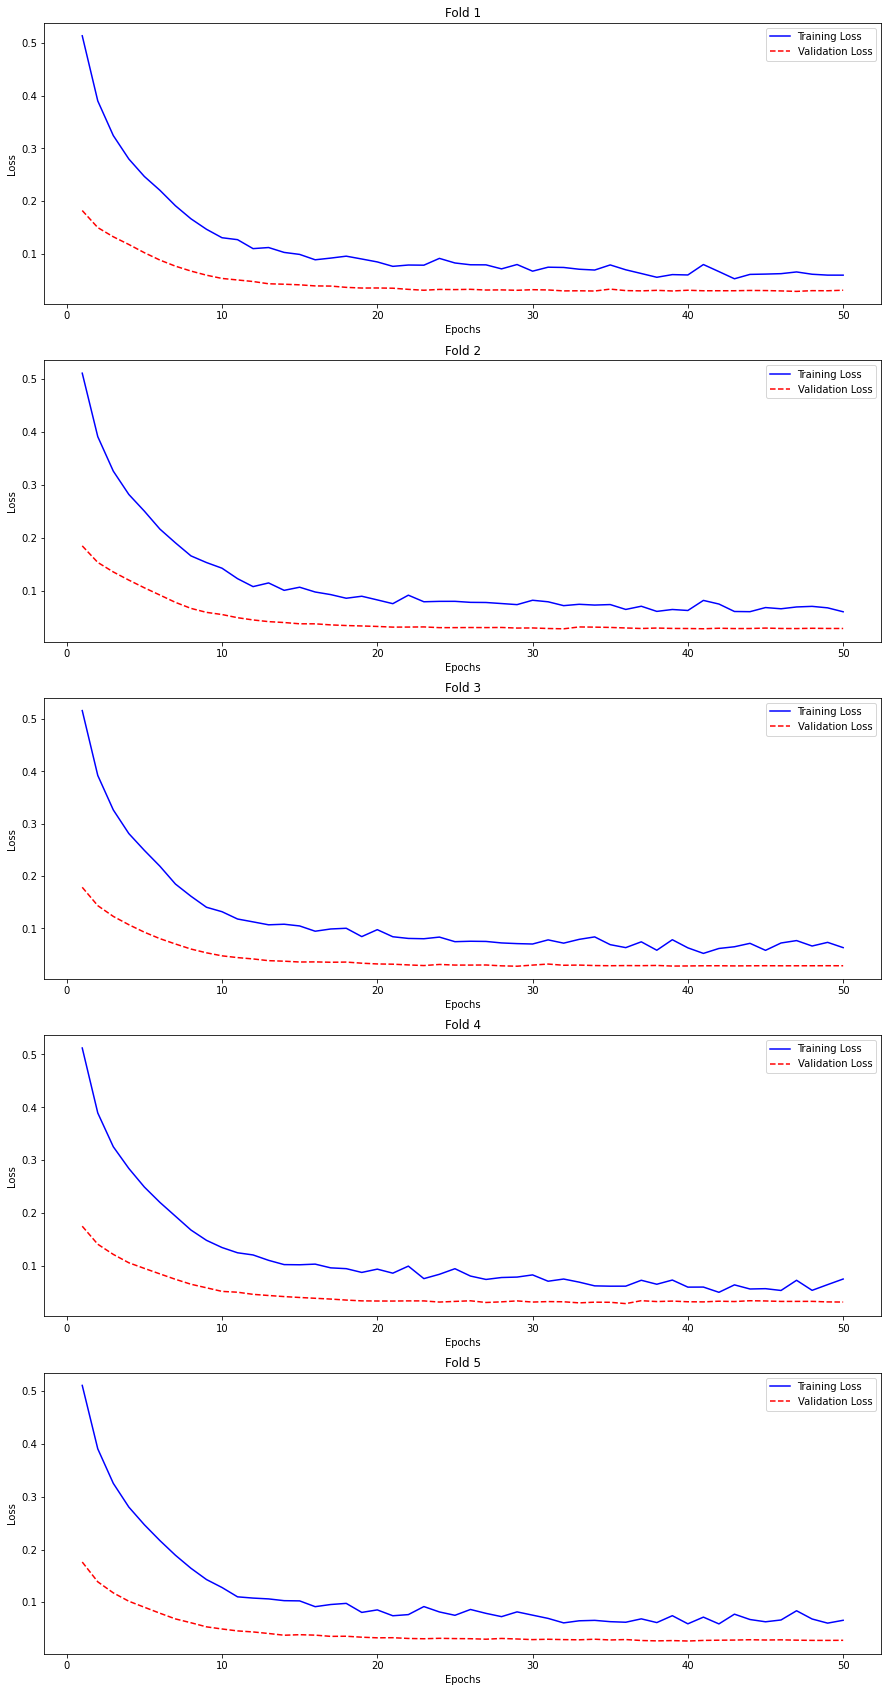

In [12]:
LP_1, Names_1, Network_1 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_1)

y_pred = eval_fn(Network_1, set(Names_1), full_tr_data, full_tr_data_setup.__len__())

print("Configuration 1 Accuracy : {:.4f} %".format(accuracy_score(y, y_pred) * 100))
breaker()

LPV = []
LPT = []
for i in range(len(LP_1)):
  LPT.append(LP_1[i]["train"])
  LPV.append(LP_1[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(15, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# Configuration 2


------------------------------

Training ...

------------------------------

Processing Fold 1
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Epoch    27: reducing learning rate of group 0 to 1.0000e-05.
Epoch    33: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2
Epoch    20: reducing learning rate of group 0 to 1.0000e-04.
Epoch    38: reducing learning rate of group 0 to 1.0000e-05.
Epoch    44: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3
Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Epoch    31: reducing learning rate of group 0 to 1.0000e-05.
Epoch    37: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.
Epoch    32: reducing learning rate of group 0 to 1.0000e-05.
Epoch    38: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 5
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.
Epoch    32: reducing lea

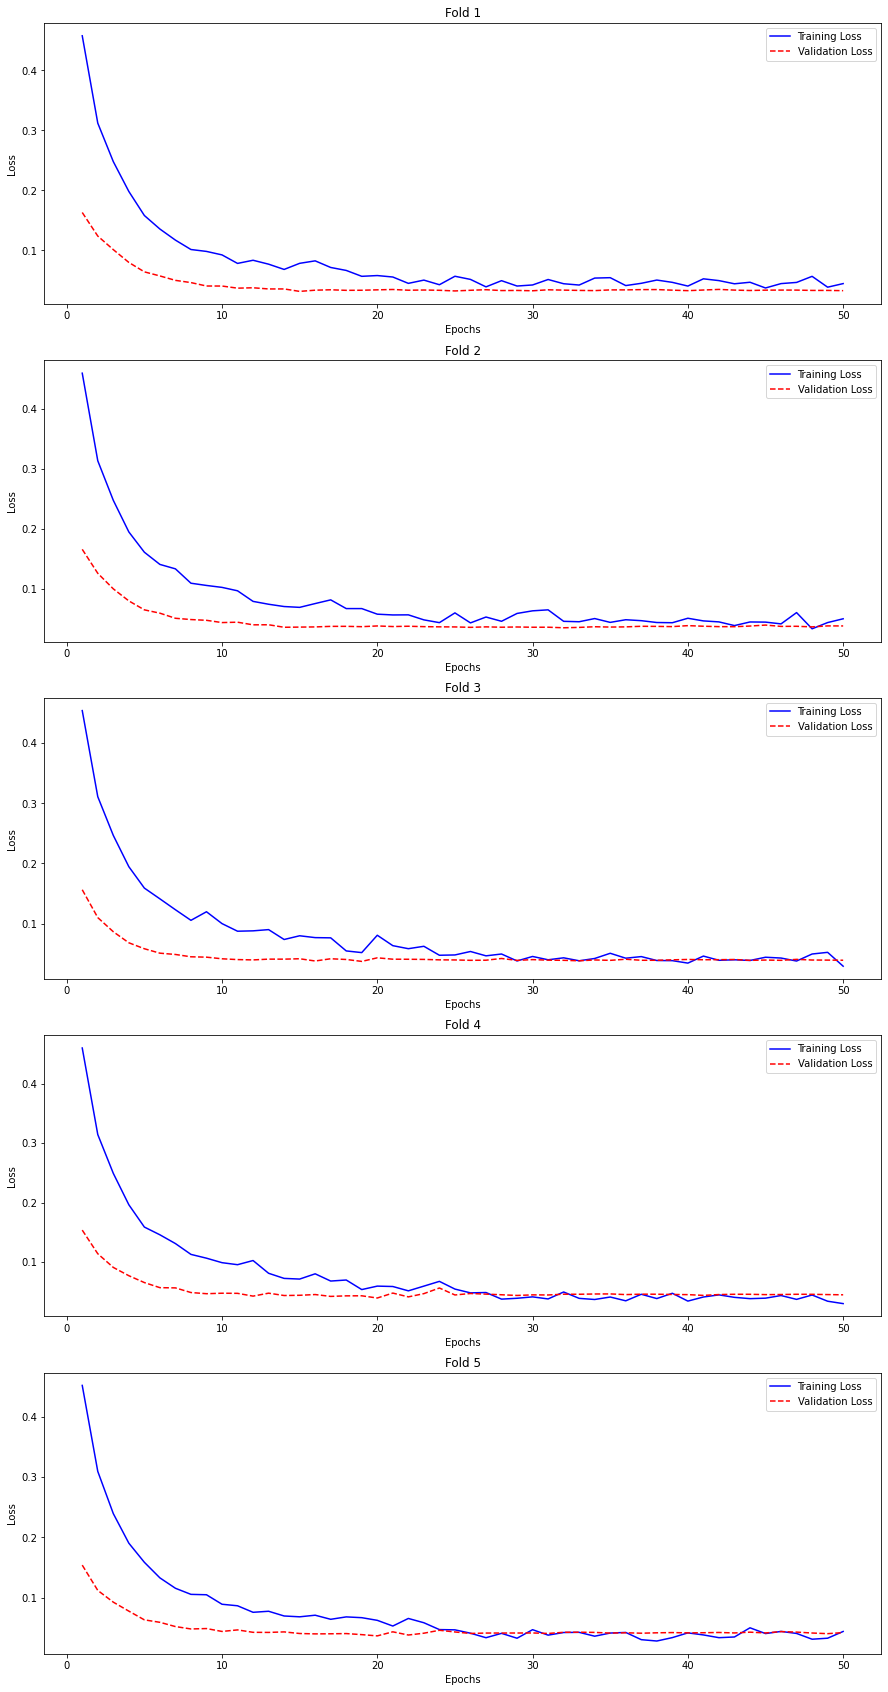

In [13]:
LP_2, Names_2, Network_2 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_2)

y_pred = eval_fn(Network_2, set(Names_2), full_tr_data, full_tr_data_setup.__len__())

print("Configuration 2 Accuracy : {:.4f} %".format(accuracy_score(y, y_pred) * 100))
breaker()

LPV = []
LPT = []
for i in range(len(LP_2)):
  LPT.append(LP_2[i]["train"])
  LPV.append(LP_2[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(15, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# Predictions

In [14]:
#y_pred = eval_fn(Network_Name, Model_Names, ts_data, ts_data_setup.__len__())